# Notebook to visualize training transforms for SELMA3D data

## Setup

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import sys
import tifffile as tiff

from monai.transforms import (
    CastToTyped,
    Compose,
    EnsureChannelFirstd,
    MapTransform,
    RandAffined,
    RandFlipd,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandRotate90d,
    RandScaleIntensityd,
    RandShiftIntensityd,
    ScaleIntensityRangePercentilesd,
    ThresholdIntensityd,
    ToTensord
)
from monai.data import Dataset, DataLoader


In [2]:
# get functions from other files
sys.path.append('/home/ads4015/ssl_project/preprocess_patches/src')
from selma3d_visualization_functions import ClampIntensityd, LoadTiffd, get_train_transforms, get_val_transforms


In [3]:
# # transform to clamp image intensity between 0-1
# class ClampIntensityd(MapTransform):
#     def __init__(self, keys, minv=0.0, maxv=1.0):
#         super().__init__(keys)
#         self.minv = minv
#         self.maxv = maxv

#     def __call__(self, data):
#         d = dict(data)
#         for key in self.keys:
#             d[key] = np.clip(d[key], self.minv, self.maxv)
#         return d


In [4]:
# # function to get training transforms
# def get_train_transforms():
#     return Compose([

#         # load
#         LoadTiffd(keys=['image']),
#         CastToTyped(keys=['image'], dtype=np.float32),

#         # normalize based on input percentiles
#         ScaleIntensityRangePercentilesd(keys=['image'], lower=1, upper=99, b_min=0.0, b_max=1.0, clip=True),

#         # spatial augmentations
#         RandFlipd(keys=['image'], spatial_axis=[0, 1, 2], prob=0.2),
#         RandRotate90d(keys=['image'], prob=0.2, max_k=3),
#         RandAffined(keys=['image'], rotate_range=(0.1, 0.1, 0.1), scale_range=(0.1, 0.1, 0.1), prob=0.2),

#         # intensity augmentations
#         RandGaussianNoised(keys=['image'], prob=0.2, mean=0.0, std=0.02),
#         RandGaussianSmoothd(keys=['image'], prob=0.2),
#         RandScaleIntensityd(keys=['image'], factors=0.2, prob=0.2),
#         RandShiftIntensityd(keys=['image'], offsets=0.2, prob=0.2),
#         ClampIntensityd(keys=["image"], minv=0.0, maxv=1.0),

#         # convert to tensor
#         ToTensord(keys=['image'])
#     ])


In [5]:
# set seed for reproducibility
random.seed(100)


In [6]:
# define paths to data
data_root = '/midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches'
data_types = ['ab_plaque', 'cfos', 'nucleus', 'vessel_eb', 'vessel_wga']


In [7]:
# choose N random files of each type
N = 3
samples = []
for dtype in data_types:
    folder = os.path.join(data_root, dtype)
    files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.tiff')]
    selected_files = random.sample(files, min(N, len(files)))
    samples += [{'image': f, 'label': dtype} for f in selected_files]

samples


[{'image': '/midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/ab_plaque/ab_plaque_sample2_C01_p2936.tiff',
  'label': 'ab_plaque'},
 {'image': '/midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/ab_plaque/ab_plaque_sample4_C01_p5863.tiff',
  'label': 'ab_plaque'},
 {'image': '/midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/ab_plaque/ab_plaque_sample1_C01_p12455.tiff',
  'label': 'ab_plaque'},
 {'image': '/midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/cfos/cfos_sample15_C01_p1611.tiff',
  'label': 'cfos'},
 {'image': '/midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/cfos/cfos_sample18_C01_p9662.tiff',
  'label': 'cfos'},
 {'image': '/midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/cfos/cfos_sample4_C01_p6788.tiff',
  'label': 'cfos'},
 {'image': '/midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/nucleus/nucleus_sample2_C01_p8523.tiff',
  'label': 'nucleus'},
 {'image': '/midtier/paetzollab/s

## Transforms

In [8]:
# get train and val transforms
train_transforms = get_train_transforms()
load_transforms = get_val_transforms()


## Visualize

In [9]:
# visualize original image and transforms
def visualize_patch(original, augmented, label, idx, filepath):

    # define center slice
    center_z = original.shape[1] // 2

    # get filename from filepath
    filename = os.path.splitext(os.path.basename(filepath))[0]

    # create plot
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    fig.suptitle(filename, fontsize=14)

    # plot original
    axs[0].imshow(original[0, center_z], cmap='gray')
    axs[0].set_title(f'Original')
    axs[1].imshow(augmented[0, center_z], cmap='gray')
    axs[1].set_title('Augmented')

    # format and show figure
    for ax in axs: ax.axis('off')
    plt.tight_layout()
    # plt.savefig(f'preview_{label}_{idx}.png') # uncomment this line to save sample images to file
    plt.show()
    

## Apply

[DEBUG] Original shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32, file: /midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/ab_plaque/ab_plaque_sample2_C01_p2936.tiff
[DEBUG] Augmented shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32
Augmented min: 0.0, max: 0.9999379515647888


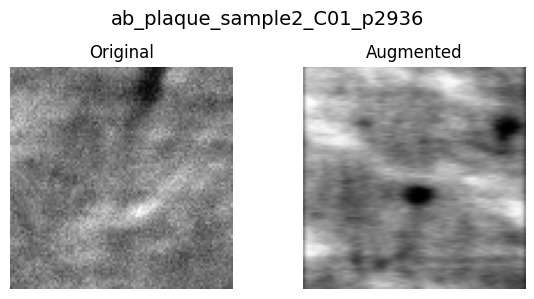

[DEBUG] Original shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32, file: /midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/ab_plaque/ab_plaque_sample4_C01_p5863.tiff
[DEBUG] Augmented shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32
Augmented min: 1.5763152987346984e-05, max: 0.996303141117096


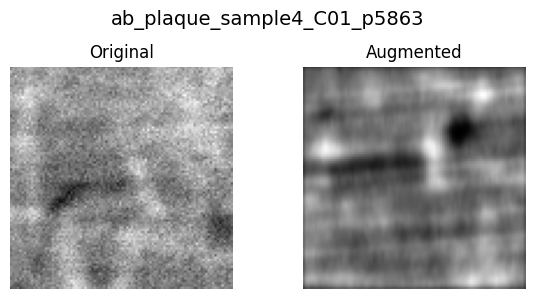

[DEBUG] Original shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32, file: /midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/ab_plaque/ab_plaque_sample1_C01_p12455.tiff
[DEBUG] Augmented shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32
Augmented min: 0.0, max: 0.9154259562492371


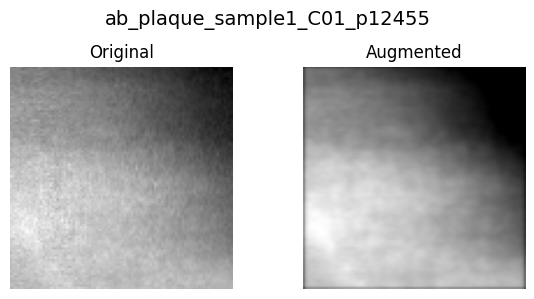

[DEBUG] Original shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32, file: /midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/cfos/cfos_sample15_C01_p1611.tiff
[DEBUG] Augmented shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32
Augmented min: 0.0, max: 1.0


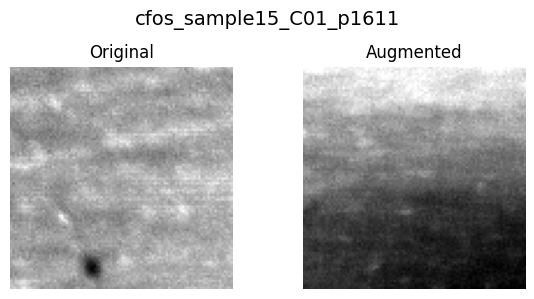

[DEBUG] Original shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32, file: /midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/cfos/cfos_sample18_C01_p9662.tiff
[DEBUG] Augmented shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32
Augmented min: 9.555951692163944e-06, max: 1.0


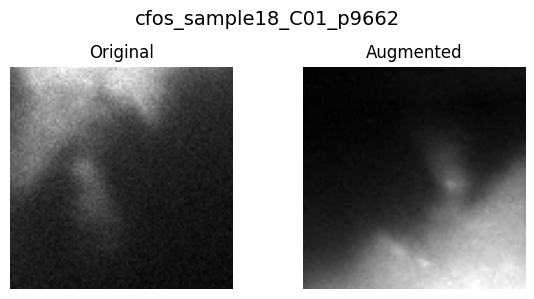

[DEBUG] Original shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32, file: /midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/cfos/cfos_sample4_C01_p6788.tiff
[DEBUG] Augmented shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32
Augmented min: 0.0, max: 1.0


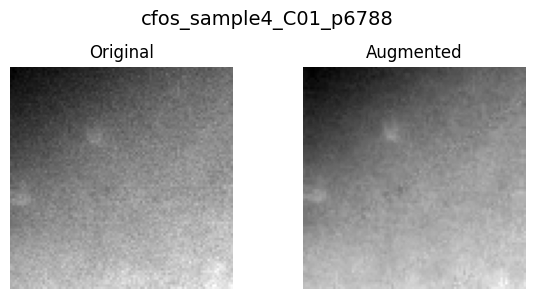

[DEBUG] Original shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32, file: /midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/nucleus/nucleus_sample2_C01_p8523.tiff
[DEBUG] Augmented shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32
Augmented min: 0.0, max: 0.8871921896934509


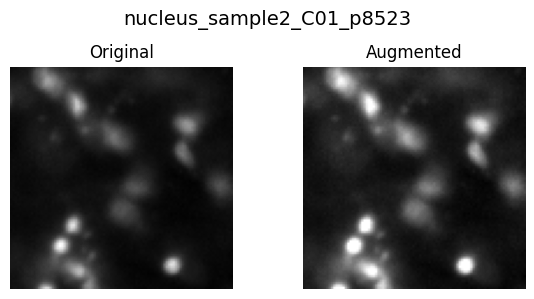

[DEBUG] Original shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32, file: /midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/nucleus/nucleus_sample2_C01_p6285.tiff
[DEBUG] Augmented shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32
Augmented min: 0.0, max: 1.0


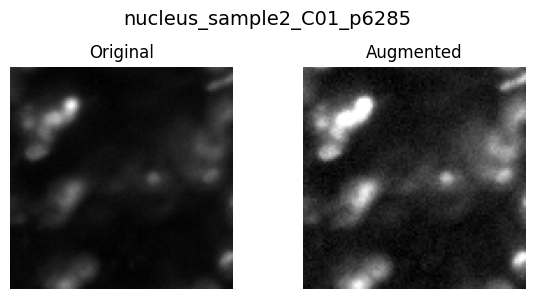

[DEBUG] Original shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32, file: /midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/nucleus/nucleus_sample1_C01_p62345.tiff
[DEBUG] Augmented shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32
Augmented min: 0.0, max: 1.0


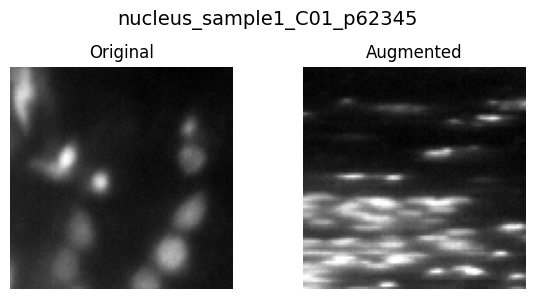

[DEBUG] Original shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32, file: /midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/vessel_eb/vessel_eb_sample4_C01_p1196.tiff
[DEBUG] Augmented shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32
Augmented min: 0.0, max: 1.0


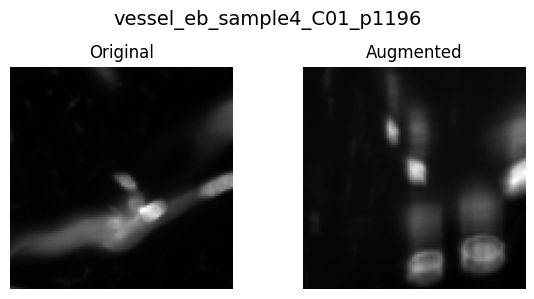

[DEBUG] Original shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32, file: /midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/vessel_eb/vessel_eb_sample6_C01_p1550.tiff
[DEBUG] Augmented shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32
Augmented min: 0.0, max: 1.0


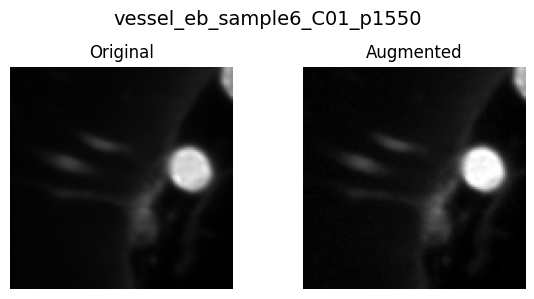

[DEBUG] Original shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32, file: /midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/vessel_eb/vessel_eb_sample8_C01_p275.tiff
[DEBUG] Augmented shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32
Augmented min: 0.0, max: 1.0


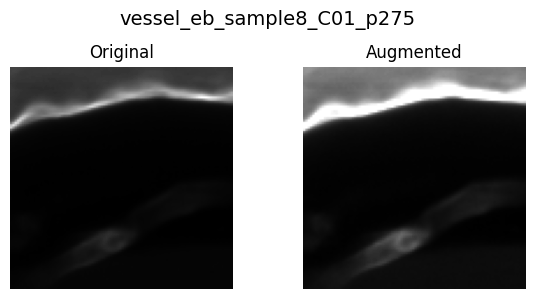

[DEBUG] Original shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32, file: /midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/vessel_wga/vessel_wga_sample1_C00_p1297.tiff
[DEBUG] Augmented shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32
Augmented min: 0.0, max: 0.9997649192810059


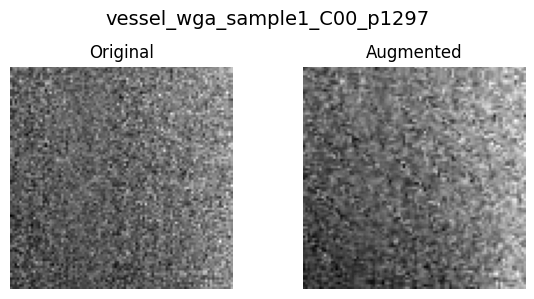

[DEBUG] Original shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32, file: /midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/vessel_wga/vessel_wga_sample4_C00_p331.tiff
[DEBUG] Augmented shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32
Augmented min: 0.0, max: 1.0


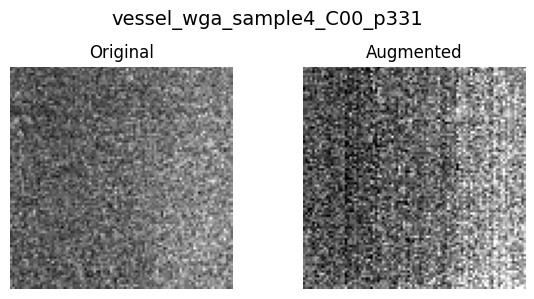

[DEBUG] Original shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32, file: /midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/vessel_wga/vessel_wga_sample1_C00_p263.tiff
[DEBUG] Augmented shape: torch.Size([1, 96, 96, 96]), dtype: torch.float32
Augmented min: 0.0, max: 1.0


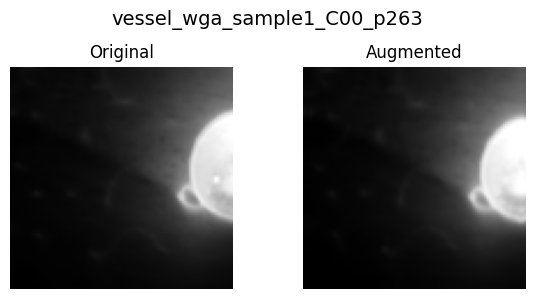

In [10]:
# loop through images and apply transformations
for i, samp in enumerate(samples):

    original = load_transforms(samp)['image']
    print(f'[DEBUG] Original shape: {original.shape}, dtype: {original.dtype}, file: {samp["image"]}')

    augmented = train_transforms(samp)['image']
    print(f'[DEBUG] Augmented shape: {augmented.shape}, dtype: {augmented.dtype}')
    print(f'Augmented min: {augmented.min()}, max: {augmented.max()}')

    
    visualize_patch(original.numpy(), augmented.numpy(), samp['label'], i, samp['image'])
